In [5]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd
import json
import os
from plotnine import *
import powerlaw
from matplotlib.lines import Line2D
import df2img
from datetime import datetime , timedelta
import scipy as sci
import statsmodels.formula.api as smf
import statsmodels.api as st
import matplotlib as mpl
import matplotlib.colors as mcolors
import seaborn as sns

# Weilun's plot


## Data

In [2]:
label_dict = {'arb_3000':'arbitrium_30bp', 'arb_500':'arbitrium_5bp', 'm_3000':'mainnet_30bp', 'm_500':'mainnet_5bp'}
def lab_token_text(text):
    # pool token
    if 'WETH' in text:
        return text.replace('WETH & ','')
    #pool label
    elif text in label_dict.keys():
        return label_dict[text]
    # CEX, trad token
    elif 'USD' in text:
        return text.replace(' & USD','')
    # CEX, trad label
    else:
        #all time frame
        if 'all' in text:
            return 'all'
        else:
            return ''
def _(text):
    if text.startswith('all '):
        return text[4:]+' all'
    elif text.startswith(' '):
        return text[1:]
    return text

In [3]:
path_for_weilun = "weilun"
file_path = f"{path_for_weilun}/rollingwindow_pool_CEX.csv"
file_path_others = f"{path_for_weilun}/others.csv"
file_path_spy_eur = f"{path_for_weilun}/SPY_EUR_over60min.csv"
file_path_5min_others = f"{path_for_weilun}/5min data.csv"
file_path_spy = f"{path_for_weilun}/SPY.csv"
file_path_eur = f"{path_for_weilun}/EUR.csv"

In [6]:
def load_data():
    df_spy = pd.read_csv(file_path_spy)
    df_euro = pd.read_csv(file_path_eur)
    df_spy["index"] = pd.to_datetime(df_spy["index"],format='mixed')
    df_euro["index"] = pd.to_datetime(df_euro["index"],format='mixed')
    return df_spy, df_euro

df_spy, df_euro = load_data()
df_spy_eur = pd.concat([df_spy,df_euro],axis=0)
df_spy_eur = df_spy_eur[["close_time", "close","open","dT","token"]]

tmp = df_spy_eur[["dT","token","close","open"]]
tmp = tmp.assign(returns=tmp["close"].apply(np.log))
tmp["returns"] = tmp.groupby(["token","dT"])["returns"].diff()
df_spy_eur = df_spy_eur.assign(returns=tmp["returns"]).dropna()
df_spy_eur.index = pd.to_datetime(df_spy_eur.set_index("close_time").index)
df_spy_eur.rename(columns={'token':'label'},inplace=True)
df_spy_eur["last_time"] = df_spy_eur["close_time"].shift(1)
df_spy_eur["close_time"] = pd.to_datetime(df_spy_eur["close_time"])
df_spy_eur["last_time"] = pd.to_datetime(df_spy_eur["last_time"])
df_spy_eur = df_spy_eur[1:]

C:\Users\std92\AppData\Local\Temp\ipykernel_26868\3452295201.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\std92\AppData\Local\Temp\ipykernel_26868\3452295201.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.


In [7]:
df_others = pd.read_csv(file_path_others)
df_others = df_others.set_index("datetime").dropna()
df_others["close_time"] = df_others.index
df_others.index = pd.to_datetime(df_others.index.to_series(), format="mixed").apply(lambda x:x.replace(tzinfo=None))
df_others.columns = ["close", "returns","dT","label", "close_time"]
df_others.loc[:,'label']=df_others.apply(lambda r: r['label'].replace('coinbase  ','').replace(' & USD','').replace('Binance  ','')   ,axis=1)

C:\Users\std92\AppData\Local\Temp\ipykernel_26868\1743051955.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`


In [8]:
df_coin = pd.read_csv(file_path)
df_coin = df_coin.set_index("Unnamed: 0").drop("volume",axis=1)
df_coin.columns = ["close","returns","dT","token","label"]
df_coin.index = pd.to_datetime(df_coin.index)
df_coin.loc[:,'label']= df_coin.apply(lambda r: _(lab_token_text(r['label'])+ f' {lab_token_text(r["token"])}')  , axis = 1)
df_coin.drop(columns='token',inplace=True)

In [9]:
df_coin_day = df_coin[df_coin["dT"] == "1D"]
df_coin_day = df_coin_day.groupby(["label"]).resample("1D").last()
df_coin_day.index = [i[1] for i in df_coin_day.index]

df_coin_hour = df_coin[df_coin["dT"] == "1H"]
df_coin_hour = df_coin_hour.groupby(["label"]).resample("1H").last()
df_coin_hour.index = [i[1] for i in df_coin_hour.index]
df_coin = pd.concat([df_coin_hour, df_coin_day])
df_coin["close_time"] = df_coin.index

C:\Users\std92\AppData\Local\Temp\ipykernel_26868\3569066885.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


In [12]:
df_5min_others = pd.read_csv(file_path_5min_others)
df_5min_others = df_5min_others.set_index("datetime", drop=False)
df_5min_others.index = pd.to_datetime(df_5min_others.index)
df_5min_others.columns = ["close_time", "close","returns","dT","label"]


In [13]:
start_time = df_coin.groupby(["label"])["close_time"].min().max()
end_time = df_coin.groupby(["label"])["close_time"].max().min()
start_time, end_time
df_spy_eur = df_spy_eur[(df_spy_eur.index > start_time) & (df_spy_eur.index < end_time)]
df_coin = df_coin[(df_coin.index > start_time) & (df_coin.index < end_time)]
df_others = df_others[(df_others.index > start_time) & (df_others.index < end_time)]
df_5min_others = df_5min_others[(df_5min_others.index > start_time) & (df_5min_others.index < end_time)]
df_spy_eur["dT"] = df_spy_eur["dT"].replace({"D":"1D", "60min":"1H"})
df_coin["dT"] = df_coin["dT"].replace({"D":"1D", "60min":"1H"})

# Statistic Jarque-Barre

$$
\text{Jarque-Barre}(X) = \frac{\text{skew}(X)}{6} + \frac{\text{kurtosis}(X) - 3}{27}
$$

##Data Preparation

In [19]:
df_spy_eur_hour = df_spy_eur[df_spy_eur["dT"]=="1H"]
df_spy_eur_hour.columns = [c.replace("token","label") for c in df_spy_eur_hour.columns]
df_coin_tmp = df_coin.copy()
df_all_stat = pd.concat([df_spy_eur_hour[df_others.columns], df_coin_tmp[df_others.columns], df_others])

In [20]:
Main = ["SPY","EUR", *df_coin_tmp["label"].unique()]
L1= ['XRP','ADA','ALGO','ATOM','AVAX','BCH','BTC','DOT','ETH','GNO','LTC','SOL']
L2 = ['OP','MATIC']
Oracle = ['LINK']
Gaming =['SAND','AXS']
Shitcoin = ['DOGE','SHIB']
DeFi = ['UNI','INJ','AAVE','SNX','MRK','OSMO','FXS','CRV','GMX','CVX','BAL']

In [349]:
df_all_stat.to_csv('Data')

,close,returns,dT,label,close_time
2021-09-23 09:55:00,442.310,0.010203,1H,SPY,2021-09-23 09:55:00
2021-09-23 10:55:00,443.890,0.003566,1H,SPY,2021-09-23 10:55:00
2021-09-23 11:55:00,443.610,-0.000631,1H,SPY,2021-09-23 11:55:00
2021-09-23 12:55:00,443.970,0.000811,1H,SPY,2021-09-23 12:55:00
2021-09-23 13:55:00,444.810,0.001890,1H,SPY,2021-09-23 13:55:00
...,...,...,...,...,...
2023-10-18 11:00:00,3.923,0.002808,1H,UNI,2023-10-18 11:00:00+00:00
2023-10-18 12:00:00,3.910,-0.003319,1H,UNI,2023-10-18 12:00:00+00:00
2023-10-18 13:00:00,3.948,0.009672,1H,UNI,2023-10-18 13:00:00+00:00
2023-10-18 14:00:00,3.925,-0.005843,1H,UNI,2023-10-18 14:00:00+00:00


In [322]:
def generate_with(df, dT="2H"):
    resampled_df = df_all_stat.groupby("label").resample(dT).last()
    resampled_df.index = resampled_df.index.droplevel(0)
    resampled_df["log_close"] = np.log(resampled_df["close"])
    resampled_df["returns"] = resampled_df.groupby("label")["log_close"].diff()
    resampled_df["dT"] = dT
    return resampled_df.dropna()

a = pd.concat([generate_with(df_all_stat, dT=f"{i}H") for i in range(1,101)])
# pd.concat([a, ])

In [275]:
def stat_plott(df, addition=""):
    fig,ax = plt.subplots(figsize=(16,8))
    time_order = [f"{i}H" for i in range(1,24)]
    for name, group in df.reset_index().groupby("label"):
        group = group.sort_values("dT")
        ax.plot(group["dT"].astype(str) + "H", group["returns"], label=name, marker="o", linestyle="-", markerfacecolor='none')
    handles, labels = ax.get_legend_handles_labels()
    n = len(handles)
    if n >= 7:
        first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1, fontsize=20)
        ax.add_artist(first_legend)
        ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9, fontsize=20 )
    else:
        ax.legend(fontsize=20)
    ax.set_ylabel('JB statics',fontsize=20)
    ax.set_xlabel('timescale',fontsize=20)
    y_max = ax.get_ylim()[1]
    ax.set_ylim(bottom=None,top=y_max*1.5)

##Jarque-Barre for hour period

In [324]:
result = a.groupby(["label","dT"])["returns"].apply(func).reset_index()

result.loc[result["label"].str.contains("|".join(Main)),'type'] = 'Main'
result.loc[result["label"].str.contains("|".join(L1)),'type'] = 'L1'
result.loc[result["label"].str.contains("|".join(L2)),'type'] = 'L2'
result.loc[result["label"].str.contains("|".join(Oracle)),'type'] = 'Oracle'
result.loc[result["label"].str.contains("|".join(Gaming)),'type'] = 'Gaming'
result.loc[result["label"].str.contains("|".join(DeFi)),'type'] = 'DeFi'
result.loc[:,'dT'] = result.apply(lambda r: int(r['dT'].replace('H','')) ,axis=1 )

In [346]:
result

,label,dT,returns,type
0,AAVE,100,-0.143260,DeFi
1,AAVE,10,0.068870,DeFi
2,AAVE,11,0.058564,DeFi
3,AAVE,12,0.070533,DeFi
4,AAVE,13,0.028367,DeFi
...,...,...,...,...
3695,mainnet_5bp USDC,96,-0.151453,Main
3696,mainnet_5bp USDC,97,-0.104748,Main
3697,mainnet_5bp USDC,98,-0.091583,Main
3698,mainnet_5bp USDC,99,-0.138706,Main


D:\Anaconda\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
D:\Anaconda\lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 1550 rows containing missing values.


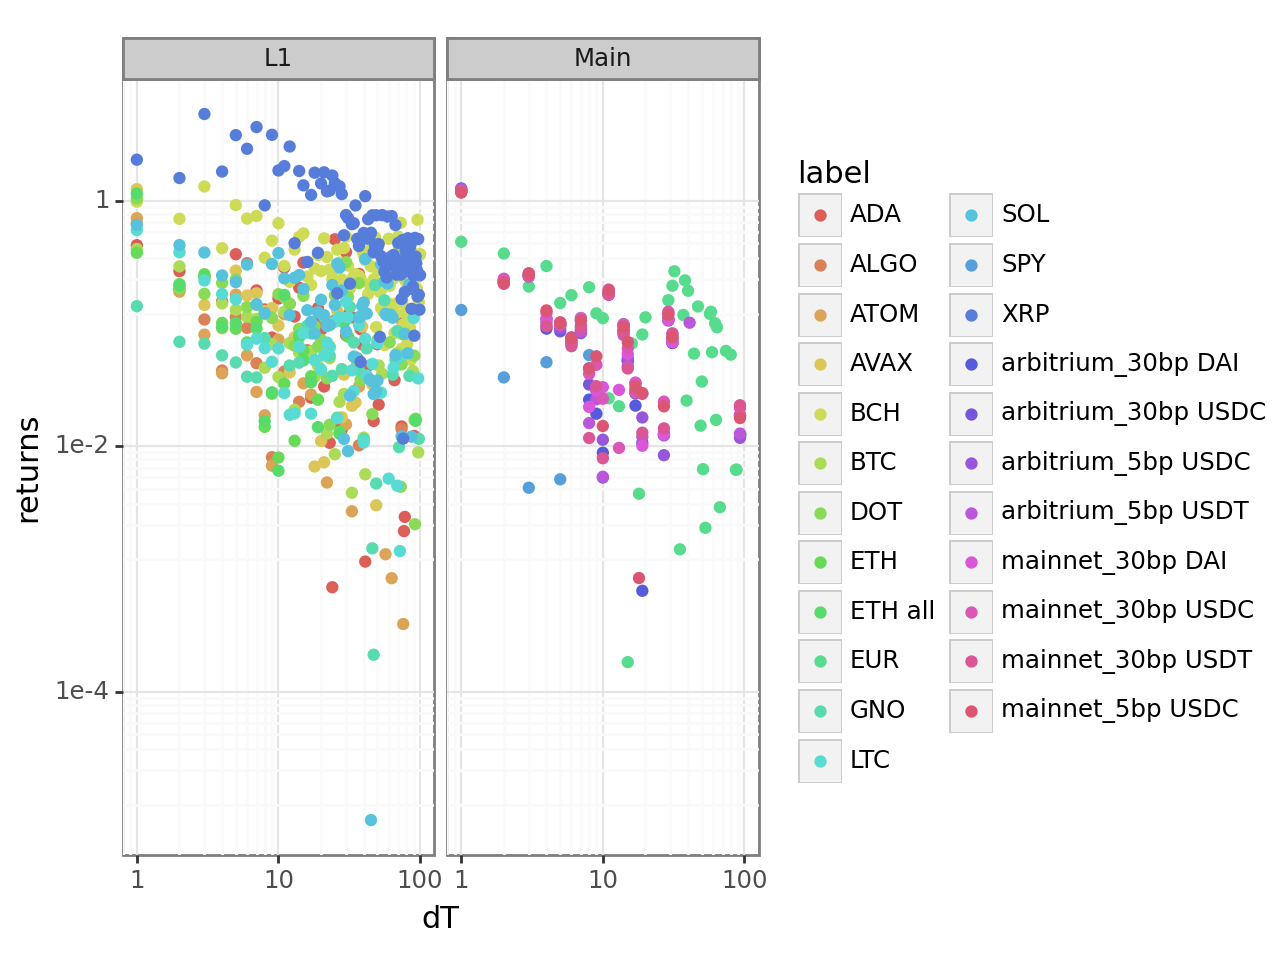

In [348]:
gp = (ggplot(result[result['type'].isin(['Main','L1'])],aes("dT","returns",color='label'))
      +geom_point()+facet_grid(".~type")+scale_x_log10()+scale_y_log10() + theme_bw() )
print(gp)

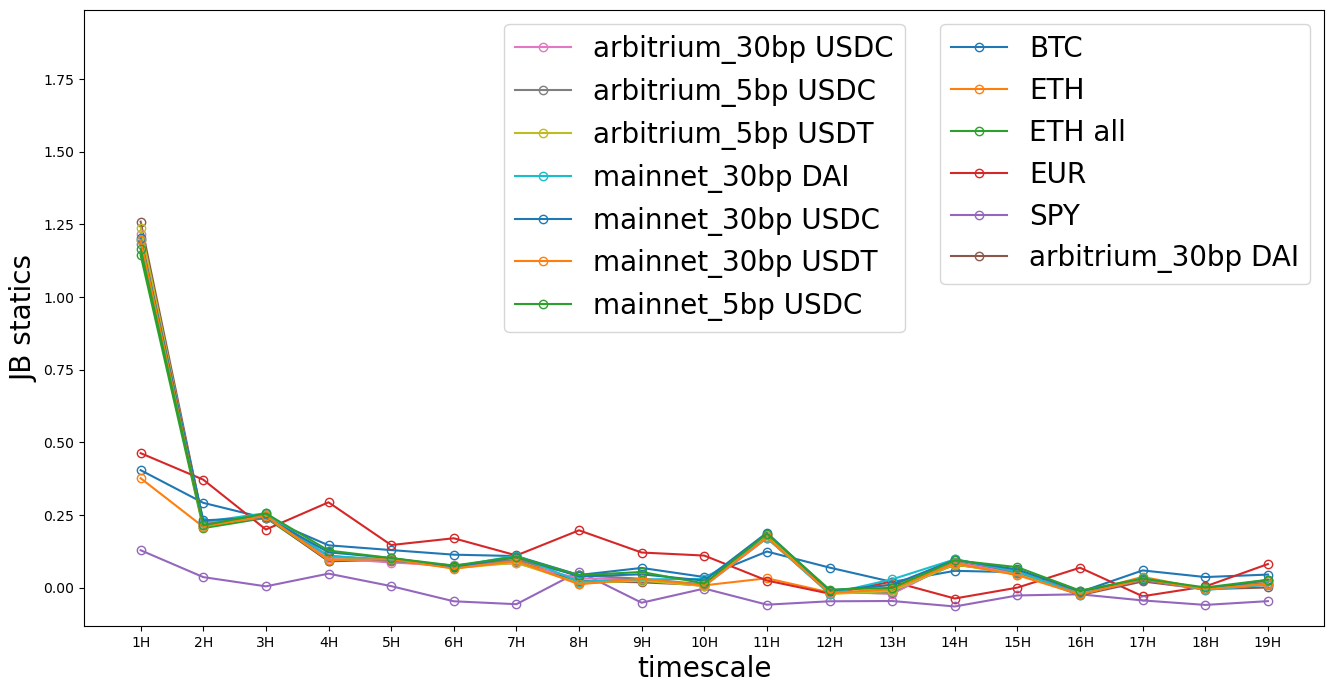

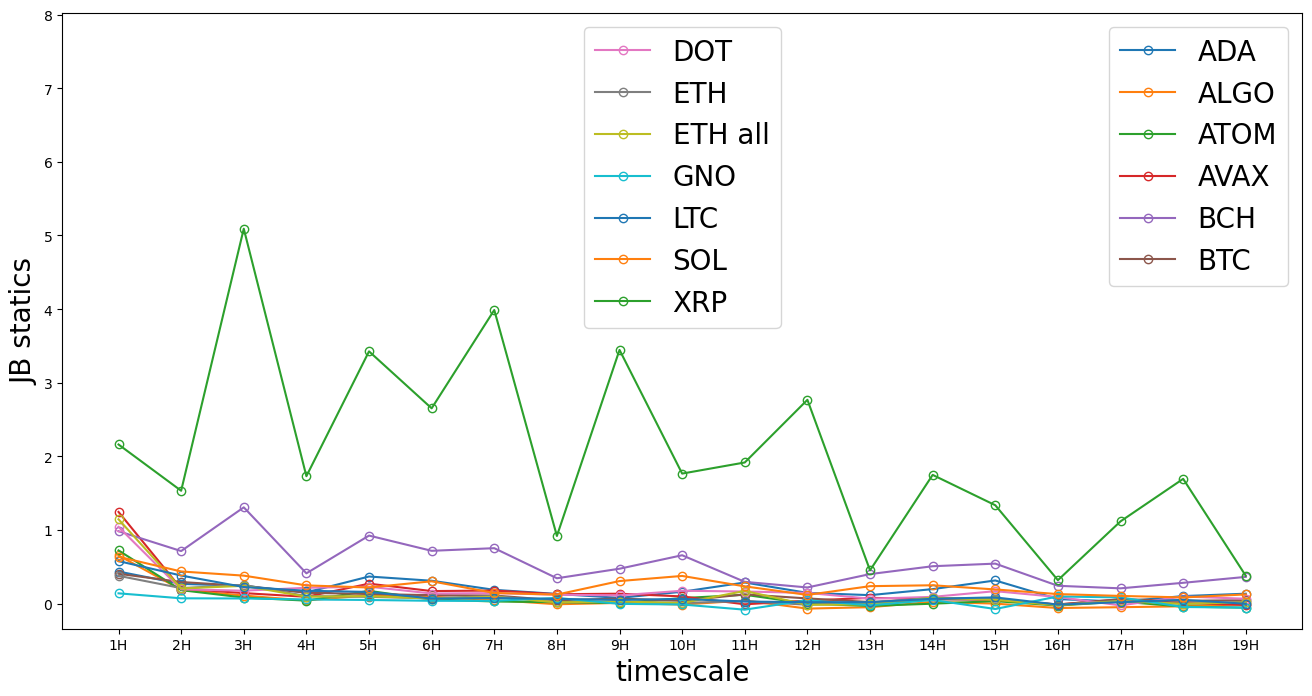

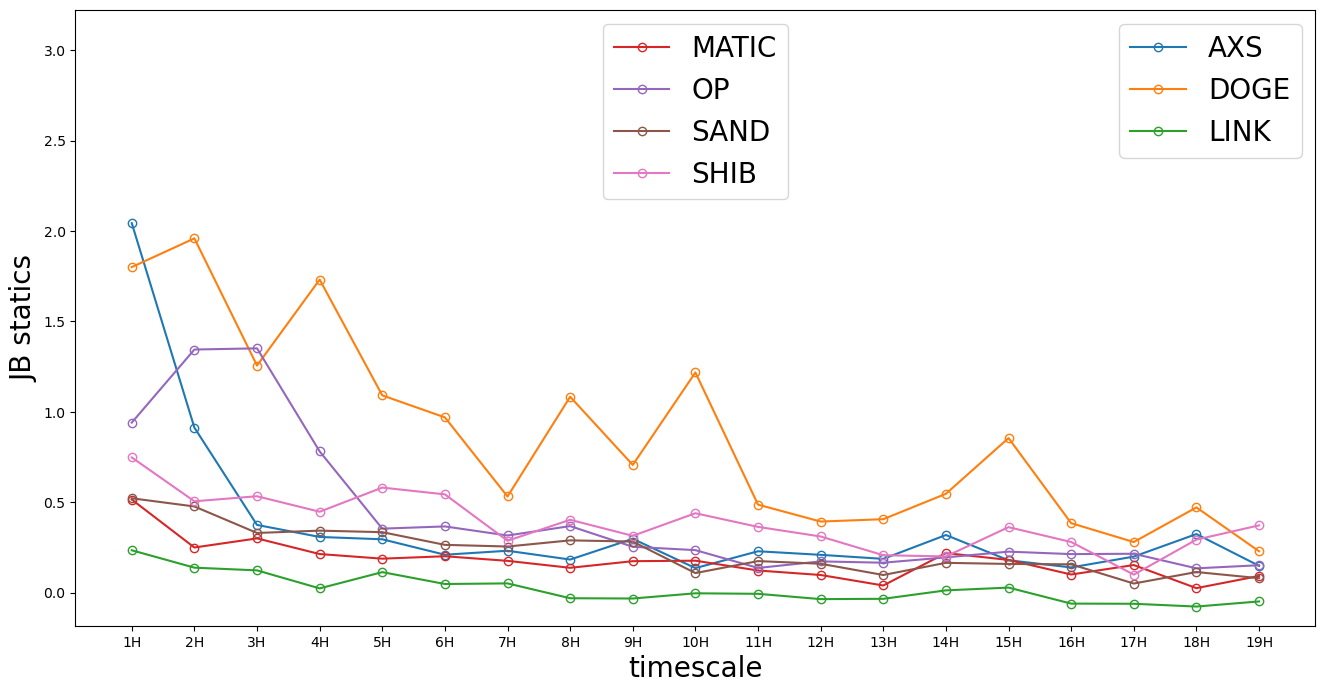

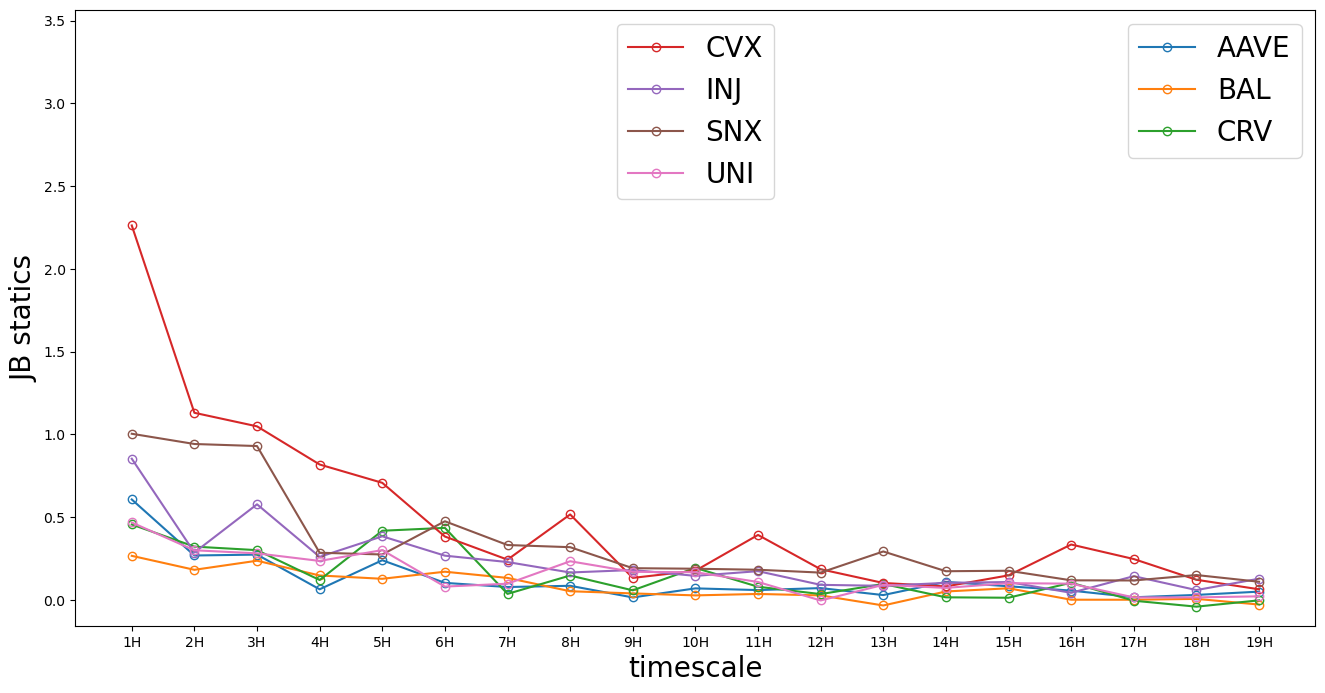

In [276]:
func = lambda x:skew(x)/6 + (kurtosis(x)-3)/27
result = a.groupby(["label","dT"])["returns"].apply(func).reset_index()
result["dT"] = result["dT"].str.rstrip("H").astype(int)

stat_plott(result[result["label"].str.contains("|".join(Main))])
stat_plott(result[(result["label"].str.contains("|".join(L1)))])
stat_plott(result[result["label"].str.contains("|".join([*L2, *Oracle, *Gaming, *Shitcoin]))])
stat_plott(result[result["label"].str.contains("|".join(DeFi))])

# Leverage Effect

$$
\text{CrossCorrelation}(k) = \sum_{t} normalize( \lvert R_t \rvert - \overline{\lvert R \rvert} ) * normalize( \text{lag}R_{t+k} - \overline{\text{lagR}})
$$

$$
\text{normalize}(x_i) = \frac{x_i - \overline{x}}{\sqrt{\sum_{i} (x_i - \overline{x})^2}}
$$


##Function implementation

In [72]:
def prep_lev(x, var_use='returns'):
    y=x.copy()
    y['lagR'] = y[var_use]
    y['absR'] = np.abs(y[var_use])
    return y

def xcross(x,what='1D',var_use='returns',title="",ax=None):
    y = prep_lev(x,var_use)

    tmp = None
    if what == "over_60": tmp = "60min"
    elif what == "1H": tmp = "60min"
    elif what == "1D": tmp = "1D"
    elif what == "1W": tmp = "1W"
    elif what == "1M": tmp = "1M"
    else: tmp = what
    if tmp != "1M" :
        if pd.Timedelta(tmp) < pd.Timedelta('1D') and x['label'].unique()[0] == "SPY":
            time_diff = pd.to_datetime(x["close_time"]) - pd.to_datetime(x["last_time"])
            y = y.loc[(time_diff <= pd.Timedelta(tmp)).index]

    a = y[y['dT'] == what].dropna()
    label = x["label"].unique()[0]
    if "label" in x.columns:
        label = f"{x['label'].unique()[0]}"

    lags, c, line, b = plt.xcorr(a['lagR']-np.mean(a['lagR']),a['absR']-np.mean(a['absR']),maxlags=20,usevlines=False,\
                    linestyle='-',normed=True,marker='o',markerfacecolor='none', label=label)

    ax.axhline(0, ls='-', color='black')
    ax.axvline(0, ls='-', color='black')
    ax.hlines(y=3/np.sqrt(a.shape[0]),xmin=-10,xmax=10,color='red',linestyles='dashed')
    ax.hlines(y=-3/np.sqrt(a.shape[0]),xmin=-10,xmax=10,color='red',linestyles='dashed')
    return a

def xcross_std(x,what='1D',var_use='returns',title="",ax=None, colorGen=None):
    y = prep_lev(x,var_use)

    a = y[y['dT'] == what].dropna()

    label = x["label"].unique()[0]
    if "label" in x.columns: label = f"{x['label'].unique()[0]}"
    s1=a['lagR'].std()
    s2=a['absR'].std()
    lags, c, line, b = plt.xcorr((a['lagR']-np.mean(a['lagR']))/(s1*np.sqrt(a.shape[0])),(a['absR']-np.mean(a['absR']))/s2,maxlags=20,usevlines=False,\
                linestyle='-',marker='o',normed=False,markerfacecolor='none', label=label)
    ax.axhline(0, ls='-', color='black')
    ax.axvline(0, ls='-', color='black')

    return np.mean(c[:len(c)//2]),np.mean(c[len(c)//2:])


def xcross_std2(x,what='1D',var_use='returns',title="",ax=None, colorGen=None):
    y = prep_lev(x,var_use)

    a = y[y['dT'] == what].dropna()
    label = x["label"].unique()[0]
    if "label" in x.columns:
        label = f"{x['label'].unique()[0]}"
    s1=a['lagR'].std()
    s2=a['absR'].std()
    lags, c, line, b = plt.xcorr((a['lagR']-np.mean(a['lagR']))/(s1*np.sqrt(a.shape[0])),(a['absR']-np.mean(a['absR']))/s2,maxlags=20,usevlines=False,\
                linestyle='-',marker='o',normed=False,markerfacecolor='none', label=label)
    ax.axhline(0, ls='-', color='black')
    ax.axvline(0, ls='-', color='black')
    return np.mean(c[:len(c)//2]),np.mean(c[len(c)//2:])

colors = ["#000000","#1f77b4","#ff7f0e","#2ca02c","#d62728","#ff6347","#8a2be2","#006400","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf","#ff1493","#ffd700","#00ff00","#ff4500","#00ced1","#ff00ff","#0000ff","#ff69b4","#556b2f","#8b0000","#ff8c00","#b22222","#4b0082","#2e8b57","#800080","#5f9ea0","#8b4513","#483d8b","#7cfc00","#ffdead","#b8860b","#d2691e","#00008b","#32cd32","#c71585","#191970","#808000"]
colorGen = itertools.cycle(colors)

df_group1 = df_others[df_others["label"].str.contains("|".join(L1))]
df_group2 = df_others[df_others["label"].str.contains("|".join(DeFi))]
df_group3 = df_others[df_others["label"].str.contains("|".join([*L2, *Oracle, *Gaming, *Shitcoin]))]

In [114]:
def leverage_plott(df, addition=""):
    min_num = df.groupby("label").count()["close"].min()
    _, ax = plt.subplots(1,1,figsize=(12,7))
    df_record = {}
    for name, group in df.groupby("label"):

        df_record[name] = xcross_std2(group,what="1H",ax=ax,colorGen=colorGen)

    ax.hlines(y=3,xmin=-10,xmax=10,color='red',linestyles='dashed')
    ax.hlines(y=-3,xmin=-10,xmax=10,color='red',linestyles='dashed')

    ax.legend(fontsize=20)
    ax.set_xlabel("Lag(days)",fontsize=25)
    ax.set_ylabel("Correlation times sqrt(N)",fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    return df_record


##Leverage Effect for hour period

In [89]:
df_spy_eur.label.unique()

array(['SPY', 'EUR'], dtype=object)

In [90]:
lev_dict=df_record.copy()

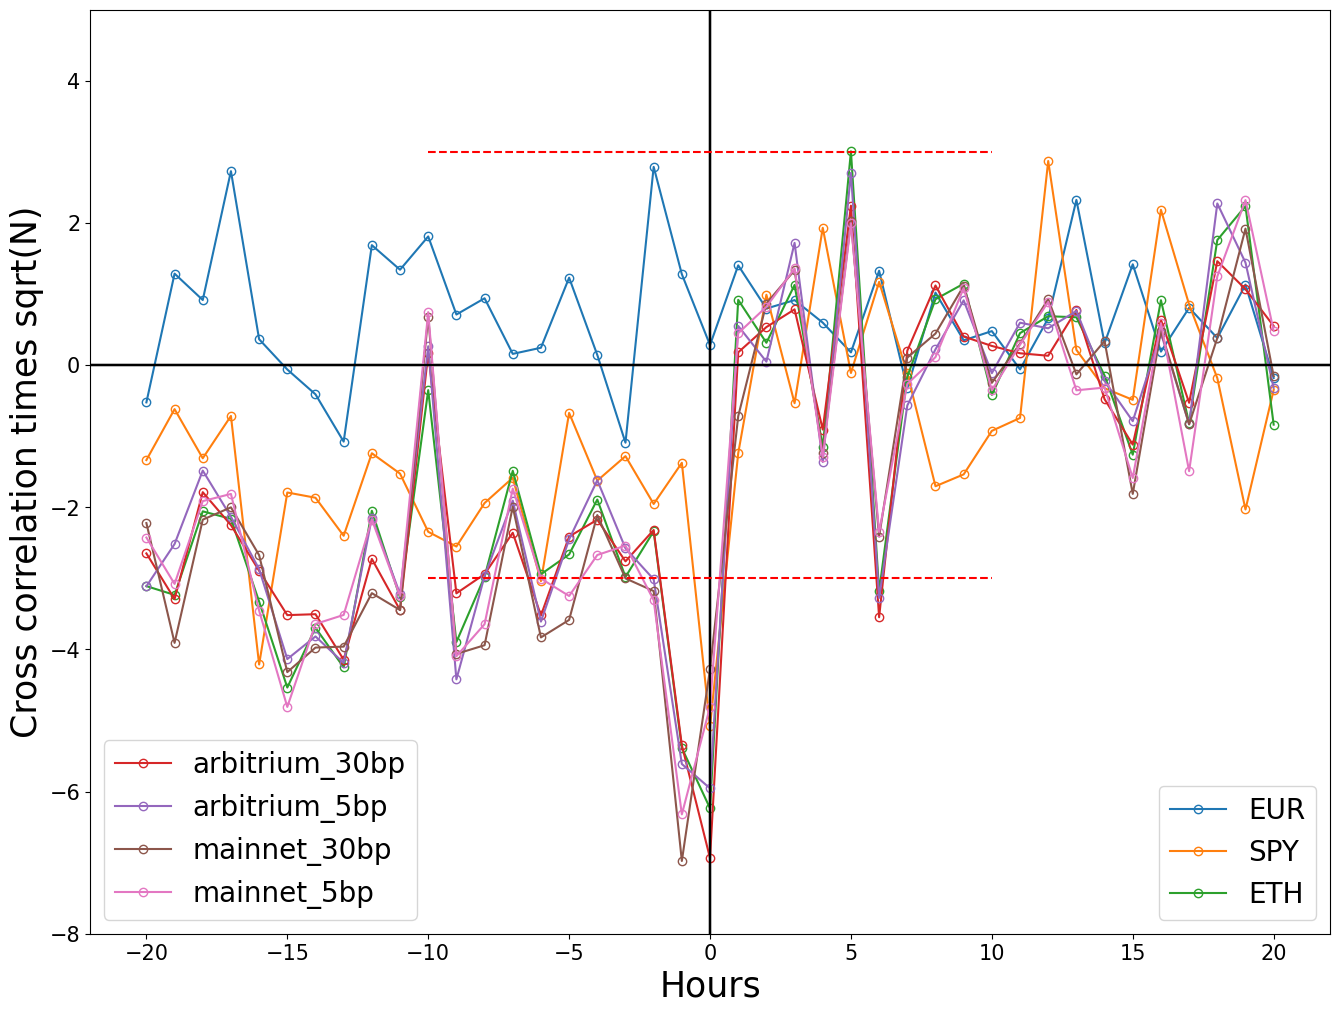

In [109]:
def receive_min_num():
    min_num = df_coin.groupby("label").count()["close"].min()
    tmp = df_spy_eur[df_spy_eur["label"] == "EUR"]
    min_num = min(min_num, len(tmp[(tmp["label"] == "EUR") & (tmp["dT"] == "1H")]))
    tmp = df_spy_eur[df_spy_eur["label"] == "SPY"]
    return min(min_num, len(tmp[(tmp["label"] == "SPY") & (tmp["dT"] == "1H")]))

_, ax = plt.subplots(1,1,figsize=(16,12))

df_record = {}
df_record["EUR"] = xcross_std(df_spy_eur[df_spy_eur["label"] == "EUR"],what='1H',var_use='returns',title="",ax=ax,colorGen=colorGen)
df_record["SPY"] = xcross_std(df_spy_eur[df_spy_eur["label"] == "SPY"],what='1H',var_use='returns',title="",ax=ax,colorGen=colorGen)

for name, group in df_coin.groupby(["label"]):
    if name[0] in ['arbitrium_30bp DAI','arbitrium_5bp USDT','mainnet_30bp USDT','mainnet_30bp DAI','BTC','ETH all']:
        continue
    df_record["".join(name)] = xcross_std(group,what="1H",ax=ax,colorGen=colorGen)

ax.hlines(y=3,xmin=-10,xmax=10,color='red',linestyles='dashed')
ax.hlines(y=-3,xmin=-10,xmax=10,color='red',linestyles='dashed')

handles, labels = ax.get_legend_handles_labels()
for i,text in enumerate(labels):
    if 'USDC' in text:
        labels[i]=text.replace(' USDC','')
n = len(handles)
first_legend = ax.legend(labels=[ labels[i] for i in range( n//2 ) ],handles=[ handles[i] for i in range( n//2 ) ], loc = 4,fontsize=20)
ax.add_artist(first_legend)
ax.legend(labels=[ labels[i] for i in  np.arange(n//2,n )  ],handles=[ handles[i] for i in np.arange(n//2,n ) ] ,loc=3,fontsize=20)
ax.set_ylim(-8,5)
ax.set_xlabel("Hours",fontsize=25)
ax.set_ylabel("Cross correlation times sqrt(N)",fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)


5

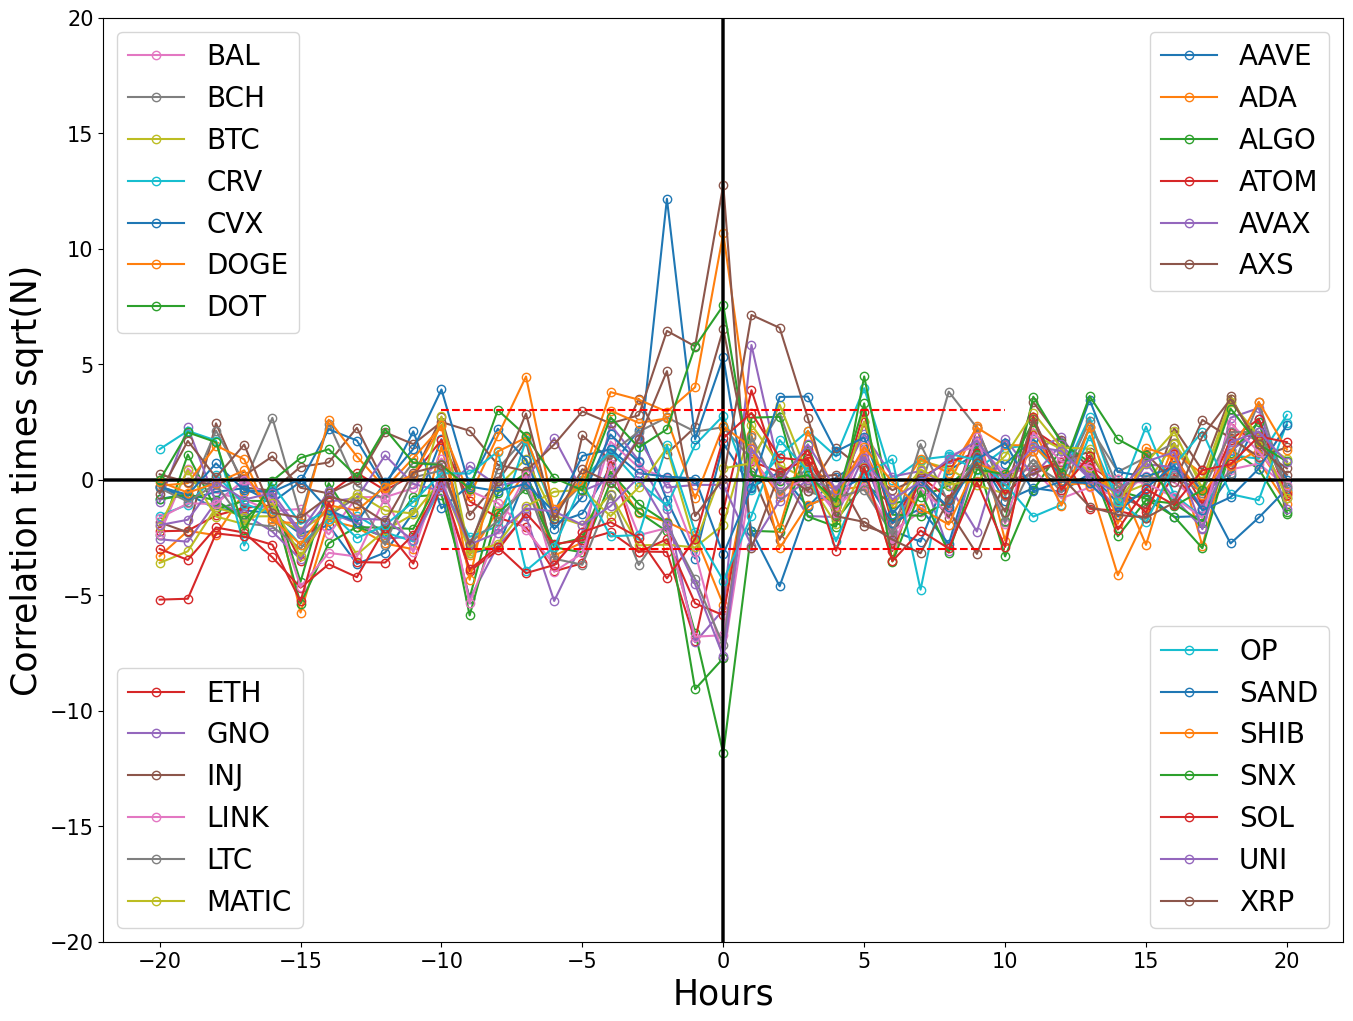

In [124]:
df = pd.concat([df_group1,df_group3,df_group2 ]).copy()

min_num = df.groupby("label").count()["close"].min()
_, ax = plt.subplots(1,1,figsize=(16,12))
df_record = {}
for name, group in df.groupby("label"):

    df_record[name] = xcross_std2(group,what="1H",ax=ax,colorGen=colorGen);

ax.hlines(y=3,xmin=-10,xmax=10,color='red',linestyles='dashed')
ax.hlines(y=-3,xmin=-10,xmax=10,color='red',linestyles='dashed')

ax.set_xlabel("Hours",fontsize=25)
ax.set_ylabel("Correlation times sqrt(N)",fontsize=25)
ax.set_ylim(-20,20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)
handles, labels = ax.get_legend_handles_labels()

n = len(handles)
first_legend = ax.legend(labels=[ labels[i] for i in range( n//4 ) ],handles=[ handles[i] for i in range( n//4 ) ], loc = 1,fontsize=20)
second_legend = ax.legend(labels=[ labels[i] for i in range( n//4 , 2*n//4 ) ],handles=[ handles[i] for i in range( n//4, 2*n//4  ) ], loc = 2,fontsize=20)
third_legend = ax.legend(labels=[ labels[i] for i in range( 2*n//4 , 3*n//4 ) ],handles=[ handles[i] for i in range( 2*n//4, 3*n//4   ) ], loc = 3,fontsize=20)

ax.add_artist(first_legend)
ax.add_artist(second_legend)
ax.add_artist(third_legend)

ax.legend(labels=[ labels[i] for i in  np.arange(3*n//4,n )  ],handles=[ handles[i] for i in np.arange(3*n//4,n ) ] ,loc=4,fontsize=20)

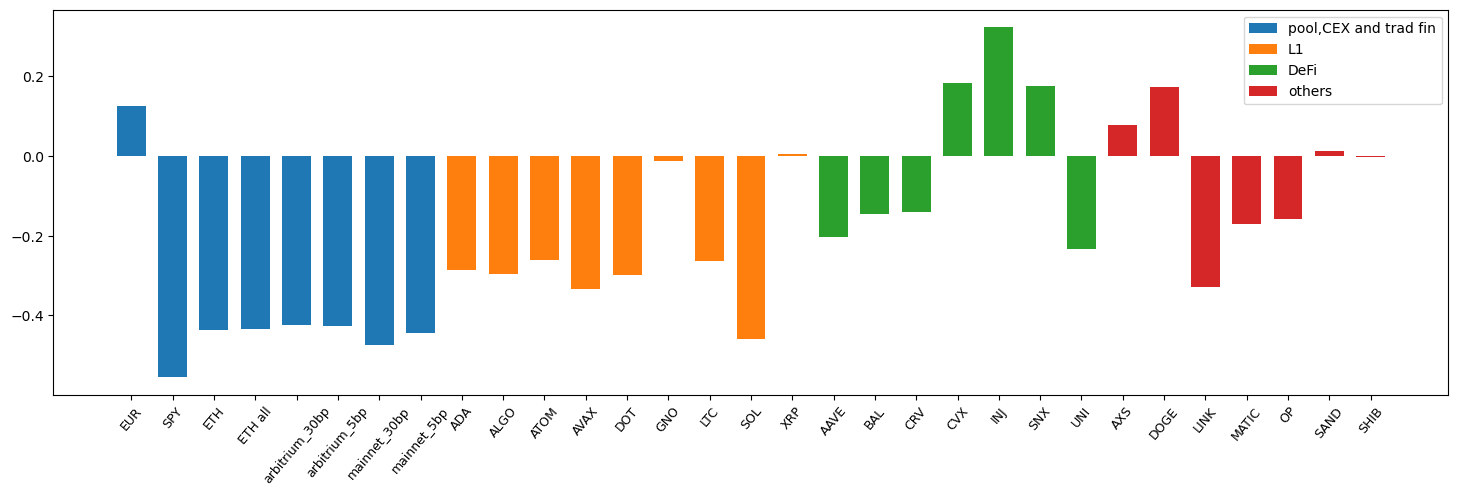

In [189]:
plt.figure(figsize=(18,5))
plt.tight_layout(pad=3.0)
pool_CEX_ =[]
for label in df_record.keys():
    if 'USDC' in label:
        label=label.replace(' USDC','')
    pool_CEX_.append(label)
plt.bar(pool_CEX_, df_record.values(), width=0.7, label="pool,CEX and trad fin")
plt.bar(df_group1_record.keys(), df_group1_record.values(), width=0.7, label="L1")
plt.bar(df_group2_record.keys(), df_group2_record.values(), width=0.7, label="DeFi")
plt.bar(df_group3_record.keys(), df_group3_record.values(), width=0.7, label="others")
plt.xticks(rotation=50,size=9)
plt.legend()
pass

# Time Reversal Asymmetry

TRA

Time period: 2021-09-23 - 2023-10-18

We calculate the time reversal asymmetry over a period as follows:

Correlation Calculations:

For each day \( d \) in the specified range \( \text{days} \), we compute:
$$
\text{corr}_d^+ = \text{corr}(\lvert R_{i+d} \rvert, \sigma_{rD})
$$

$$
\text{corr}_d^- = \text{corr}(\lvert R_{i-d} \rvert, \sigma_{rD})
$$

Cumulative Sum of Differences:
$$
\text{CumulativeSum}(d) = \sum_{i=1}^{d} \left( \text{corr}_i^- - \text{corr}_i^+ \right)
$$


##Function implementation

In [191]:
def time_rev_day(spx,dT='60min',days=np.arange(1,22)):
    a =  spx[spx['dT']==dT].copy()
    a["Date"] = pd.to_datetime(a["close_time"])
    a['day'] = a['Date'].dt.date
    a["log_close"] = a["close"].apply(np.log)
    a['rD'] = a.groupby('day')['log_close'].diff()
    b = pd.DataFrame(a.groupby('day')['rD'].std())
    b['open'] = a.groupby('day')['open'].first().to_numpy()
    b['close'] = a.groupby('day')['close'].last().to_numpy()
    b['R'] = np.log(b['close'])-np.log(b['open'])
    b['S'] = b['rD']-np.mean(b['rD'])
    c_mat = np.zeros([len(days),2])
    for d in days:
        tb = b.copy()
        #tb= b
        tb['h'] = tb['R'].shift(d)
        tb['f'] = tb['R'].shift(-d)
        tb = tb.dropna()
        c_mat[d-1,0] = np.corrcoef(np.abs(tb['h']),tb['rD'])[0,1]
        c_mat[d-1,1] = np.corrcoef(np.abs(tb['f']),tb['rD'])[0,1]
    return c_mat


def time_rev_day_5min(spx,dT='5min',days=np.arange(1,22)):
    a =  spx[spx['dT']==dT].copy()
    a["Date"] = pd.to_datetime(a["close_time"])
    a['hour'] = a['Date'].dt.floor('H')
    a['log_close'] = a['close'].apply(np.log)
    a['rH'] = a.groupby('hour')['log_close'].diff()
    b = pd.DataFrame(a.groupby('hour')['rH'].std())
    b.columns = ["std"]
    b['open'] = a.groupby('hour')['open'].first().to_numpy()
    b['close'] = a.groupby('hour')['close'].last().to_numpy()
    b['R'] = np.log(b['close']) - np.log(b['open'])

    c_mat = np.zeros([len(days),2])
    for d in days:
        tb = b[['R', 'std']].copy()
        tb['h'] = tb['R'].shift(d)
        tb['f'] = tb['R'].shift(-d)

        tb = tb.dropna()
        c_mat[d-1,0] = np.corrcoef(np.abs(tb['h']),tb['std'])[0,1]
        c_mat[d-1,1] = np.corrcoef(np.abs(tb['f']),tb['std'])[0,1]
    return c_mat


colors = ["#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#ff6347", "#8a2be2", "#006400", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#ff1493", "#ffd700", "#00ff00", "#ff4500", "#00ced1", "#ff00ff", "#0000ff", "#ff69b4", "#556b2f", "#8b0000", "#ff8c00", "#b22222", "#4b0082", "#2e8b57", "#800080", "#5f9ea0", "#8b4513", "#483d8b", "#7cfc00", "#ffdead", "#b8860b", "#d2691e", "#00008b", "#32cd32", "#c71585", "#191970", "#808000"]
colorGen = itertools.cycle(colors)

## Time reversal asymmetry for hour period

In [203]:
df_5min_others.label.unique()

array(['arb_3000  WETH & USDC', 'arb_3000  WETH & DAI',
       'arb_500  WETH & USDC', 'arb_500  WETH & USDT',
       'm_3000  WETH & USDC', 'm_3000  WETH & DAI', 'm_500  WETH & USDC',
       'Binance  ETH & USD', 'Binance all  ETH & USD',
       'Binance  BTC & USD'], dtype=object)

In [193]:
c_spy_5min = time_rev_day_5min(df_spy_eur[df_spy_eur["label"] == "SPY"],dT='5min',days=np.arange(1,20))
c_eur_5min = time_rev_day_5min(df_spy_eur[df_spy_eur["label"] == "EUR"],dT='5min',days=np.arange(1,20))

# Why Hourly TRA?

(-0.2, 0.9)

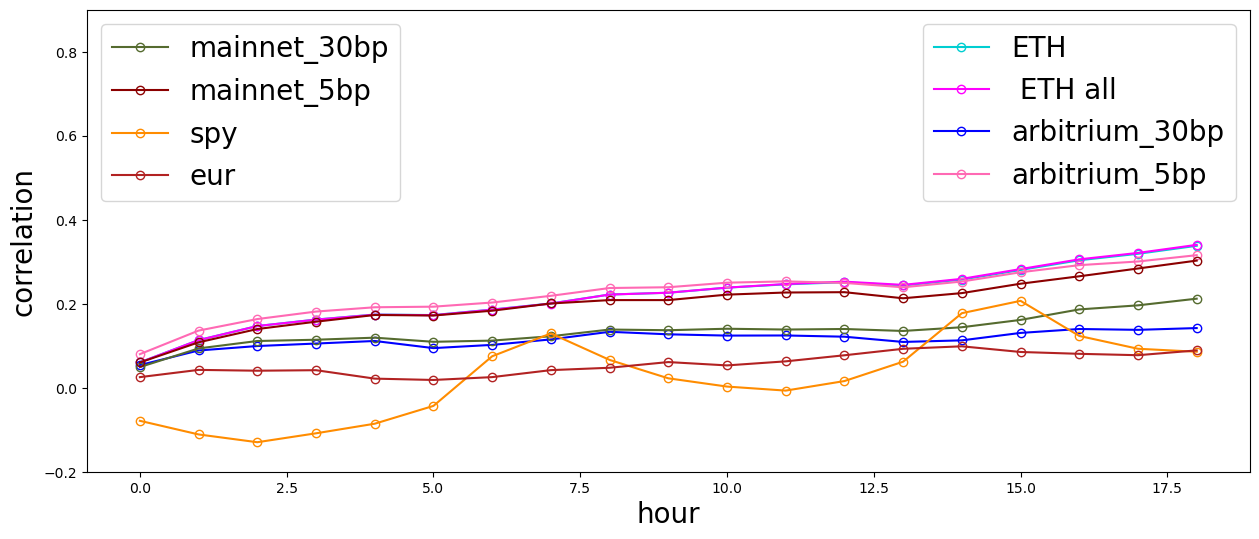

In [249]:
fig,ax = plt.subplots(figsize=(15,6))
df_all_hour = dict()
for name, group in df_5min_others.groupby(["label"]):
    if any( s in name[0] for s in ['DAI','USDT','BTC']):
        continue
    if 'Binance' in name[0]:
        label =_(name[0].replace(' & USD','').replace('Binance ',''))
    else:
        label = label_dict[name[0].replace('  WETH & USDC','')]
    group["open"] = group["close"]
    data = time_rev_day_5min(group,dT='5min',days=np.arange(1,20))
    df_all_hour[" ".join(name)] = np.cumsum(data.T[0] - data.T[1])[-1]
    ax.plot(np.cumsum(data.T[0] - data.T[1]),linestyle='-',marker='o',markerfacecolor='none',label=label, color=next(colorGen))

ax.plot(np.cumsum(c_spy_5min.T[0] - c_spy_5min.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="spy", color=next(colorGen))
ax.plot(np.cumsum(c_eur_5min.T[0] - c_eur_5min.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="eur", color=next(colorGen))

handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize = 20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2,fontsize = 20)
    
ax.set_xlabel("hour",fontsize=20)
ax.set_ylabel("cumulative sum",fontsize=20)
ax.set_ylim(-0.2,0.9)


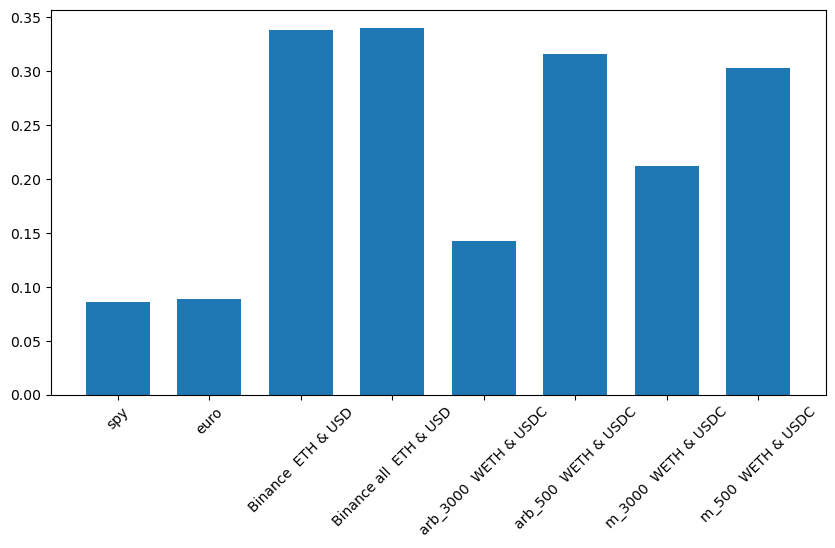

In [245]:
plt.figure(figsize=(10,5))
plt.tight_layout(pad=3.0)
keys = ["spy","eur", *df_all_hour.keys()]
values = [np.sum(c_spy_5min.T[0] - c_spy_5min.T[1]), np.sum(c_eur_5min.T[0] - c_eur_5min.T[1]), *df_all_hour.values()]
plt.bar(keys, values, width=0.7)
plt.xticks(rotation=45)
pass

##Time reversal asymmetry for day period

In [253]:
c_spy = time_rev_day(df_spy_eur[df_spy_eur["label"] == "SPY"],dT='1H',days=np.arange(1,20))
c_eur = time_rev_day(df_spy_eur[df_spy_eur["label"] == "EUR"],dT='1H',days=np.arange(1,20))

Text(150.09722222222223, 0.5, 'difference of corr with positive and negative delay')

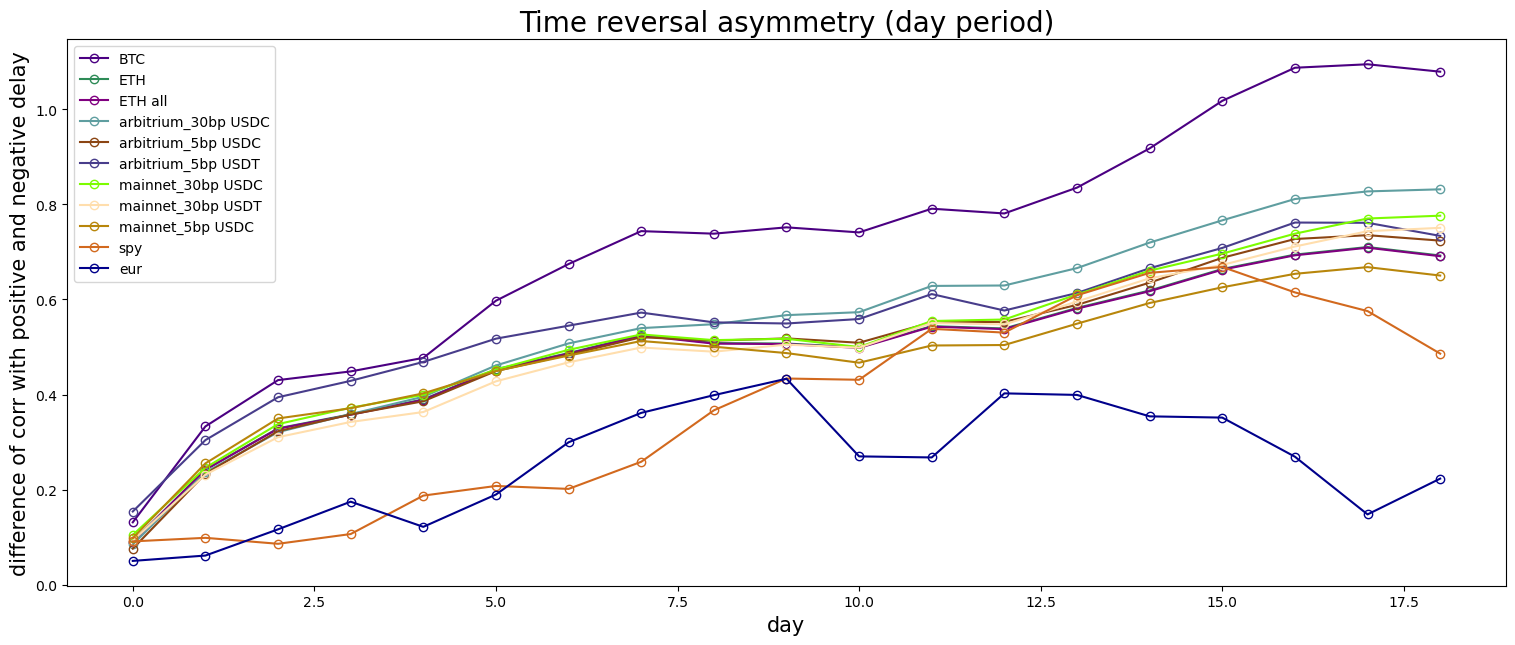

In [257]:
plt.figure(figsize=(15,6))
df_coin_records = dict()
for name, group in df_coin.groupby(["label"]):
    if name[0] in ["Binance all"] or "DAI" in name[0]:
        continue
    group["open"] = group["close"]
    data = time_rev_day(group,dT='1H',days=np.arange(1,20))
    df_coin_records[" ".join(name)] = np.cumsum(data.T[0] - data.T[1])[-1]

    plt.plot(np.cumsum(data.T[0] - data.T[1]),linestyle='-',marker='o',markerfacecolor='none',label=f"{name[0]}", color=next(colorGen))

plt.plot(np.cumsum(c_spy.T[0] - c_spy.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="spy", color=next(colorGen))
plt.plot(np.cumsum(c_eur.T[0] - c_eur.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="eur", color=next(colorGen))

legend = plt.legend()
plt.tight_layout()
plt.title("Time reversal asymmetry (day period)", fontsize=20)
plt.xlabel("day",fontsize=15)
plt.ylabel("difference of corr with positive and negative delay",fontsize=15)

In [258]:
df_group1 = df_others[df_others["label"].str.contains("|".join(L1))]
df_group2 = df_others[df_others["label"].str.contains("|".join(DeFi))]
df_group3 = df_others[df_others["label"].str.contains("|".join([*L2, *Oracle, *Gaming, *Shitcoin]))]

In [259]:
def TRA_plott(df, addition=""):
    plt.figure(figsize=(15,6))
    df_record = dict()
    for name, group in df.groupby("label"):
        if "INJ" in name:
            continue
        group["open"] = group["close"]
        data = time_rev_day(group,dT='1H',days=np.arange(1,20))
        df_record[name] = np.sum(data.T[0] - data.T[1])
        plt.plot(np.cumsum(data.T[0] - data.T[1]),linestyle='-',marker='o',markerfacecolor='none',label=f"{name}", color=next(colorGen))

    # plt.plot(np.cumsum(c_spy.T[0] - c_spy.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="spy", color=next(colorGen))
    # plt.plot(np.cumsum(c_eur.T[0] - c_eur.T[1]),linestyle='-',marker='o',markerfacecolor='none',label="eur", color=next(colorGen))
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.title("Time reversal asymmetry (day period) " + addition, fontsize=20)
    plt.xlabel("day",fontsize=15)
    plt.ylabel("difference of corr with positive delay and negative delay",fontsize=15)
    return df_record

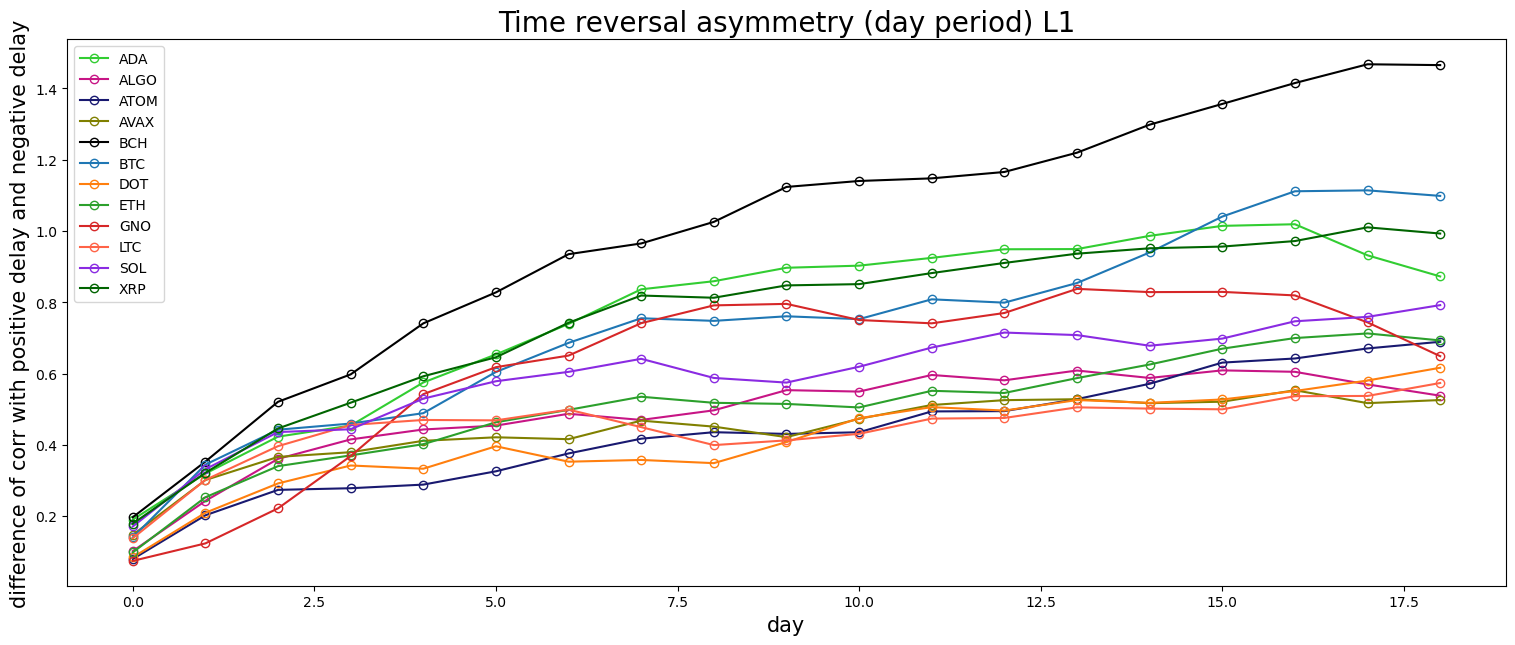

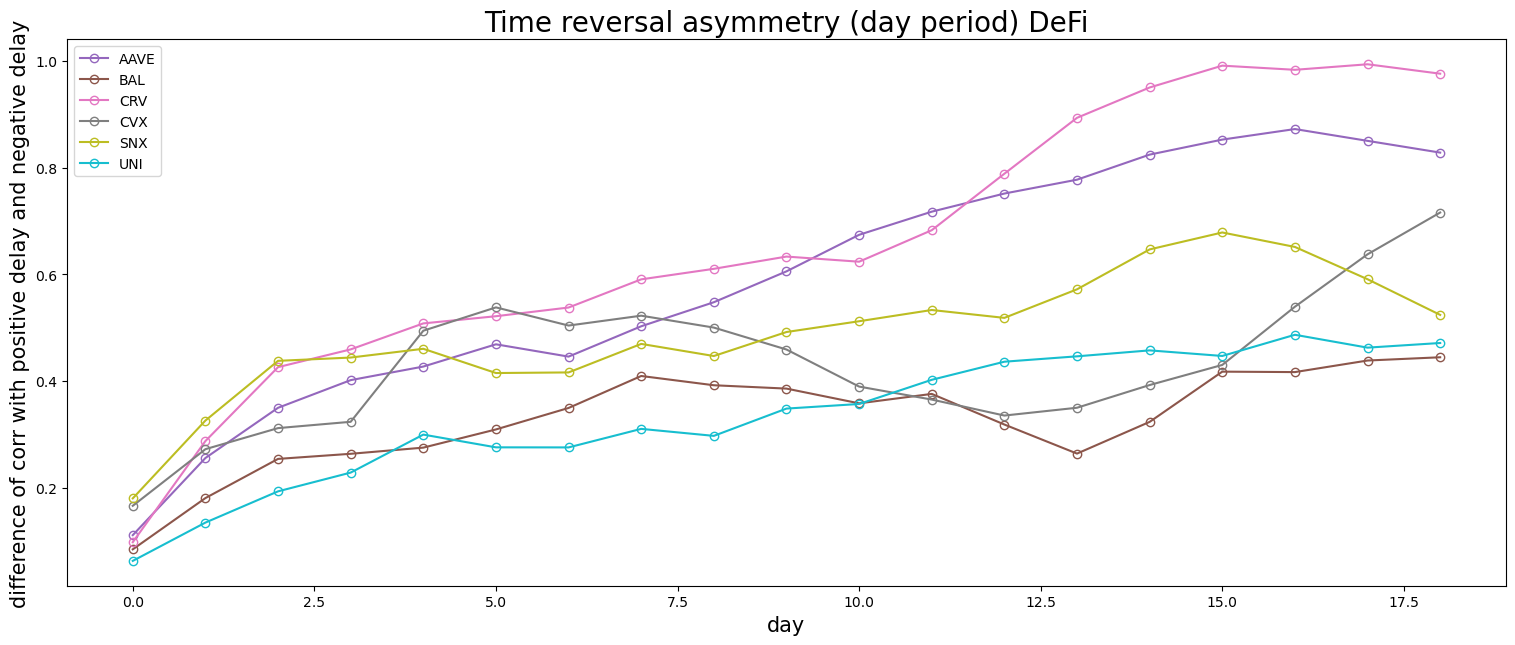

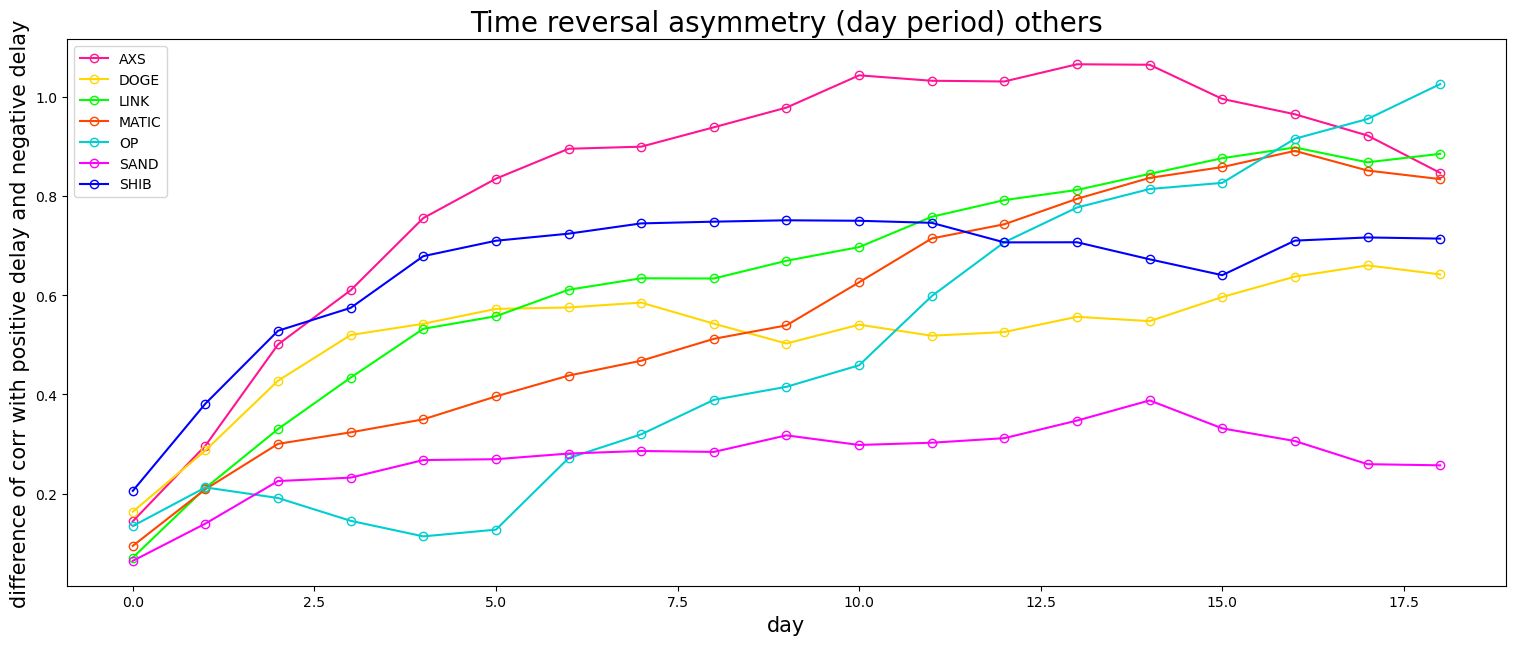

In [260]:
df_group1_record = TRA_plott(df_group1,addition="L1")
df_group2_record = TRA_plott(df_group2,addition="DeFi")
df_group3_record = TRA_plott(df_group3,addition="others")

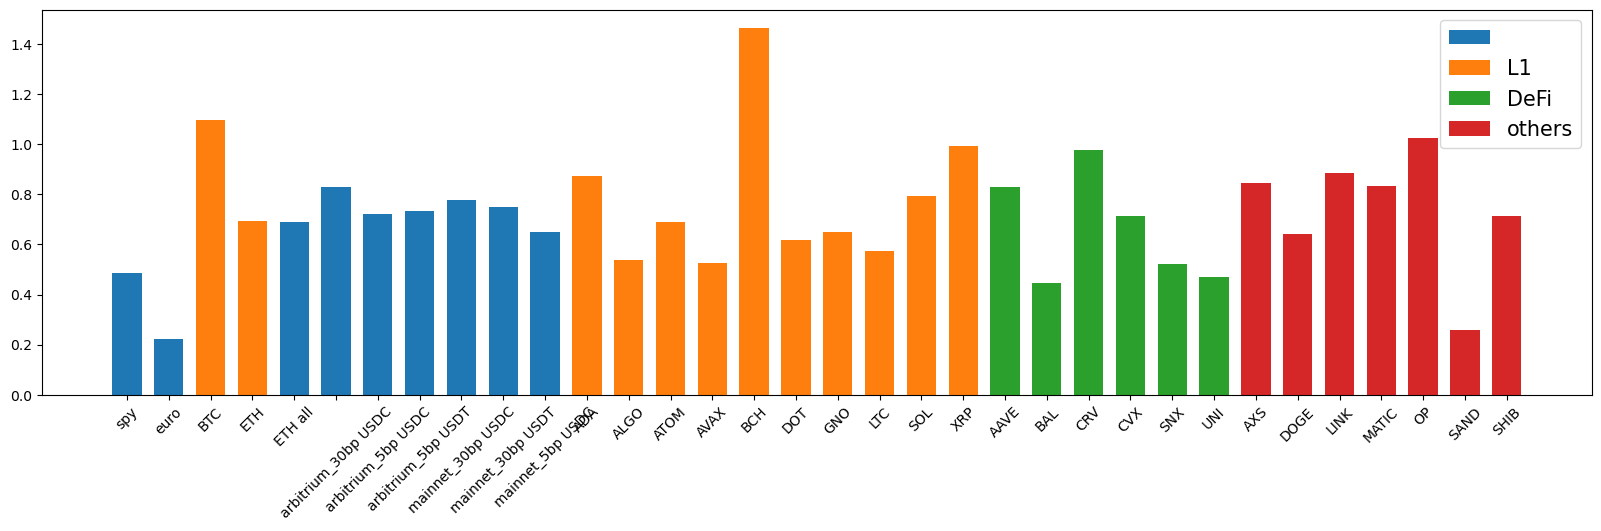

In [261]:
plt.figure(figsize=(20,5))
plt.tight_layout(pad=3.0)
keys = ["spy","euro", *df_coin_records.keys()]
values = [np.sum(c_spy.T[0] - c_spy.T[1]), np.sum(c_eur.T[0] - c_eur.T[1]), *df_coin_records.values()]
plt.bar(keys, values, width=0.7, label=" ")
plt.bar(df_group1_record.keys(), df_group1_record.values(), width=0.7, label="L1")
plt.bar(df_group2_record.keys(), df_group2_record.values(), width=0.7, label="DeFi")
plt.bar(df_group3_record.keys(), df_group3_record.values(), width=0.7, label="others")
plt.xticks(rotation=45)
plt.legend(fontsize=15)
pass